In [2]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_result
from analyze_tools import plot_tools as pt
import analyze_tools.monte_carlo as at

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative


In [3]:
s = red.sigma_Ar_Xe
e = red.epsilon_Ar_Xe

re = s * 2 ** (1/6)
k = 4 * e * (156 * (s**12 / re**14) - 42 * (s**6 / re**8))
mu = red.mass_dict['Ar'] * red.mass_dict['Xe'] / (red.mass_dict['Ar'] + red.mass_dict['Xe'])
omega = np.sqrt(k / mu)

vib_freq = omega / (2 * np.pi * red.c * red.sigma)
vib_freq

22.766978335022763

In [41]:
#
# Define paths to pickle files and functions
#

def assert_path(path):
    try: 
        assert os.path.isdir(path)
    except AssertionError:
        raise Exception("Path {} is not exist".format(path))

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

ROOT2 = "pickle_jar/"

# define lists of temperature
temperature_list = ['292.0', '200.0']
seed_list = [715, 82] # seed for free field case, the order match temperature_list
#seed_list = [29200, 20000] # seed for free field case, the order match temperature_list
seed_list2 = [198,93,998] # seed for cavity field case, the order match c_list
c_list = ['Lxy1e1','Lxy15', "Lxy2e1"] #

# define patterns of paths that lead to pickle file
freefield_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0".format(t,s)
cavityfield_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zero_0_0-c_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    assert_path(freefield_path(temp, seed_list[i]))
    
for i, c in enumerate(c_list):
    assert_path(cavityfield_path('200.0', seed_list2[i], c))

fig_root = "figure/manuscript/"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

FREEFIELD_RESULT_DICT = { # result in free field path
    temp: freefield_path(temp,seed_list[i])
    for i, temp in enumerate(temperature_list)
}
CAVITYFIELD_RESULT_DICT2 = { # result in cavity field path
    c: cavityfield_path('200.0',seed_list2[i], c)
    for i, c in enumerate(c_list)
}

def field_spectra(result_dict, limit = None):
    rad_profile = []
    
    for i, rd in result_dict.items():

        if limit and i > limit : 
            continue
        
        Afield = rd["field"]
        
        rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
        omega = red.convert_wavenumber(Afield.k_val)
        omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)
        
        foo = np.argsort(omega_profile)
        omega_profile = np.array(omega_profile)[foo]
        final_rad_profile = np.array(final_rad_profile)[foo]
        
        rad_profile.append(final_rad_profile)
        
    rad_profile = np.mean(rad_profile, axis = 0)
    
    return omega_profile, np.array(rad_profile)

def getall_colliding_time(result_dict_path, limit = None):
    result_dict = categorizing_result(result_dict_path, '')
    
    all_colliding_time = np.array([])
    
    for i, rd in result_dict.items():
        if limit and i > limit: 
            continue
            
        atoms = rd['atoms']
        
        time = at.get_colliding_time(atoms, dipole_threshold = 0)
    
        all_colliding_time = np.hstack([all_colliding_time, time])

    del result_dict
        
    return all_colliding_time

def dipole_spectra(result_dict, h, time_frame = None, windows = 'Gaussian'):
    dp_vel_list = []
    max_len = 0

    if time_frame: 
        ti, tf = time_frame
    
    for i in result_dict.keys():
        dp_vel = np.array(result_dict[i]['atoms'].observable['dipole_velocity'])

        if time_frame: 
            time = np.array(result_dict[i]['atoms'].observable['t'])
            time -= time[0]
            dp_vel = dp_vel[(time > ti) * (time < tf)]

        if np.all(np.isclose(dp_vel, 0)):
            continue
        
        dp_vel_list.append(dp_vel)
        if len(dp_vel) > max_len:
            max_len = len(dp_vel)
    
    # Pad the list of dipole velocity 
    dp_vel_array = np.zeros((len(dp_vel_list), max_len, 3))
    
    for i, dp_vel in enumerate(dp_vel_list):
        dp_vel_array[i, 0:len(dp_vel), :] = dp_vel
    
    IR_spec = []
    
    for i, dp_vel in enumerate(dp_vel_array):
        autocorr = calc_ACF(dp_vel)
        #autocorr = scipy.signal.correlate(dp_vel, dp_vel)
        yfft = calc_FFT(autocorr, windows)
        intensity = np.sum(yfft, axis=1)[0:int(len(yfft)/2)]
        IR_spec.append(intensity)
    
    IR_spec = np.mean(np.array(IR_spec), axis = 0)
    
    delta_t = red.convert_time(h) * 1e-12 * 3e10
    wavenumber = np.fft.fftfreq(len(yfft), delta_t)[0:int(len(yfft)/2)]

    return np.array(wavenumber), np.array(IR_spec)

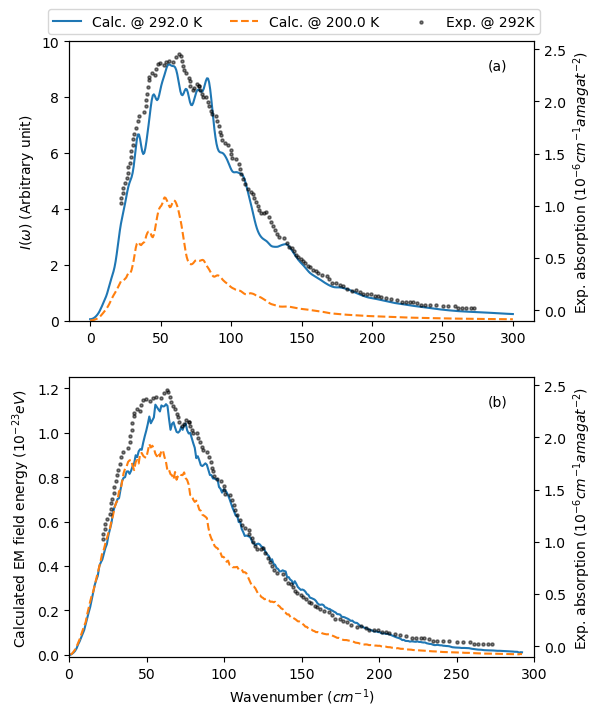

In [15]:
## from copy import deepcopy

fig,ax = plt.subplots(2, figsize = (6,8))

for i in [0,1]:
    tax = ax[i].twinx()
    exp_data = pd.read_csv('data/plot-data.csv')
    tax.scatter(
        exp_data.loc[:,'x'],
        exp_data.loc[:,' y'],
        s = 5, alpha = 0.5, c = 'black', 
        label = 'Exp. @ 292K' if i == 0 else None
    )
    tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_DICT.items()):
    
    freefield_result_dict = categorizing_result(freefield_result_path, '')

    w, spec = dipole_spectra(freefield_result_dict, 1e-2, windows = 'Gaussian')
    spec *= 1e5
    spec = spec[ w < 300 ]
    w = w[w < 300]
    ax[0].plot(w, spec, linestyle = linestyle_list[i])
    
    omega_profile, rad_profile = field_spectra(freefield_result_dict) 
    rad_profile *= 1e23
    o, f = pt.moving_average(omega_profile, rad_profile, w = 10)
    ax[1].plot(o, f, label = "Calc. @ {} K".format(temp), linestyle = linestyle_list[i])

    del freefield_result_dict
    
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax[1].set_xlim(0,300)
ax[0].set_ylim(-0.01,10)
ax[1].set_ylim(-0.01,1.25)
ax[0].set_ylabel(r"$I(\omega)$ (Arbitrary unit)")
ax[1].set_ylabel(r"Calculated EM field energy $(10^{-23} eV)$")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

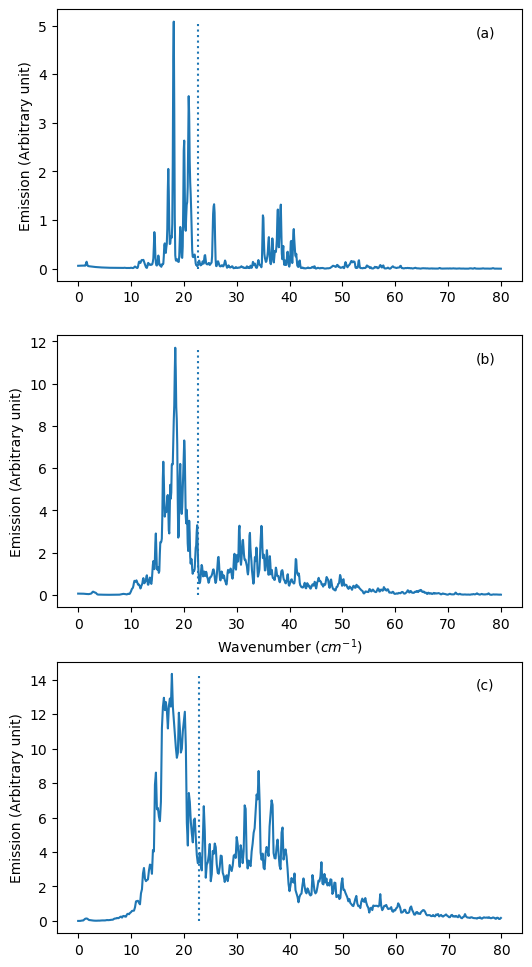

In [47]:
fig,ax = plt.subplots(3, figsize = (6,12))

for i, (cs, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):
    
    cavityfield_result_dict = categorizing_result(CAVITYFIELD_RESULT_DICT2[cs], '')
    
    wn, spec1 = dipole_spectra(cavityfield_result_dict, 1e-2,time_frame = (5.0, 5000.0), windows = 'Gaussian')
    
    #w, s = pt.moving_average(wn_real, spec1, w = 2)
    spec1 = spec1[wn < 80] * 1e6
    wn = wn[wn < 80]
    ax[i].plot(wn, spec1, label = "T = {} K".format(temp))
    ax[i].vlines(vib_freq, min(spec1), max(spec1), linestyle = 'dotted')
    
    del cavityfield_result_dict

ax[0].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_ylabel("Emission (Arbitrary unit)")
ax[2].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_xlabel("Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "cavity_spectrum_peak.jpeg",dpi = 600,bbox_inches = 'tight')

In [ ]:
fig,ax = plt.subplots(3, figsize = (6,12))

freefield_result_dict = categorizing_result(FREEFIELD_RESULT_DICT['200.0'], '')

omega_profile, rad_profile = field_spectra(freefield_result_dict) 
rad_profile *= 1e23
#ax[1].scatter(omega_profile, rad_profile, s = 5)
of, ff = pt.moving_average(omega_profile, rad_profile, w = 12)

for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):
    
    cavityfield_result_dict = categorizing_result(cavityfield_result_path, '')
    
    omega_profile, rad_profile = field_spectra(cavityfield_result_dict, limit = 0) 
    rad_profile *= 1e3
    #ax[i].scatter(omega_profile, rad_profile, s = 5)
    o, f = pt.moving_average(omega_profile, rad_profile, w = 12)
    ax[i].plot(
        o, f, label = "Cavity spectra @ 200 K" if i == 0 else None
    )
    #ax[i].vlines(23, min(rad_profile), max(rad_profile), linestyle = 'dotted')

    tax = ax[i].twinx()
    tax.plot(
        of, ff, 
        label = "Free field spectra @ 200K" if i == 0 else None, 
        linestyle = linestyle_list[2]
    )
    
    del cavityfield_result_dict

    ax[i].set_ylabel(r"Cavity field energy ($10^{-3} eV$)")
    tax.set_ylabel(r"Free field energy ($10^{-23} eV$)")
    
    ax[i].set_xlim(0,300)

del freefield_result_dict
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=2)

#ax[0].set_ylim(-0.001,0.18)
#ax[1].set_ylim(-0.1,13)
#ax[2].set_ylim(-0.1,28)

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

In [52]:
np.sum(ct > 5) * 100 / len(ct2)

0.0744047619047619

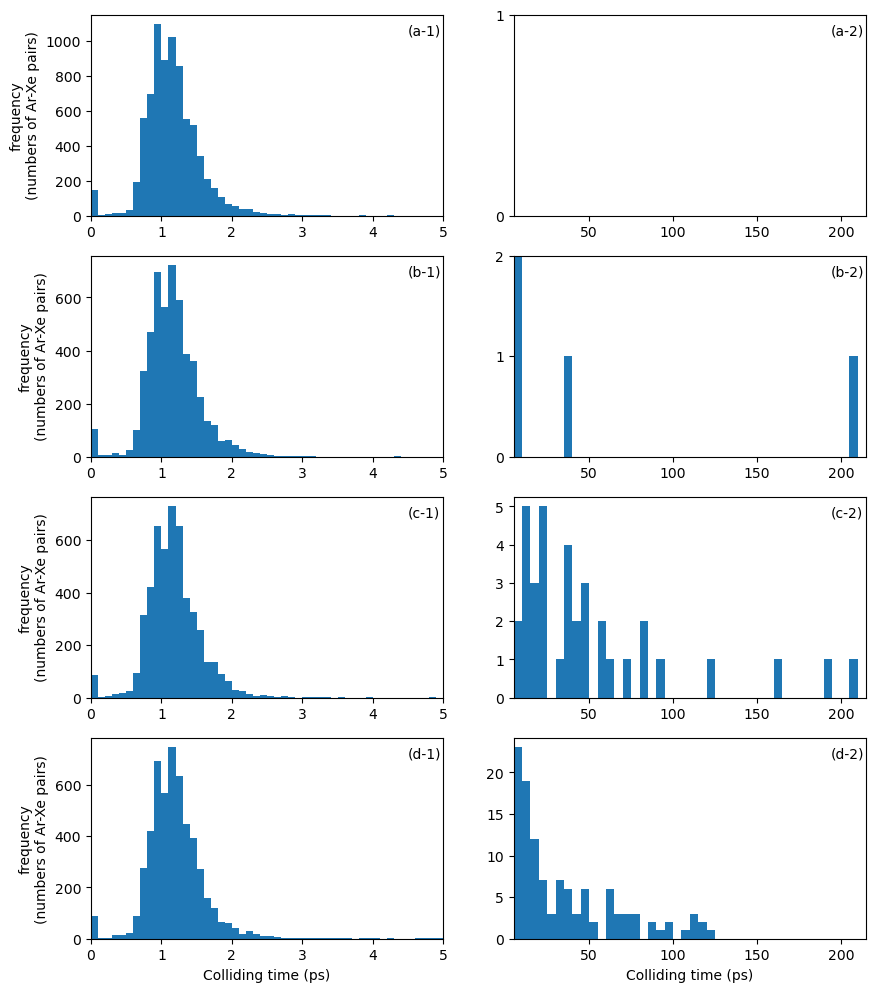

In [20]:
freefield_result_dict = FREEFIELD_RESULT_DICT['200.0']
cavityfield_result_dict = CAVITYFIELD_RESULT_DICT2['Lxy1e1']
cavityfield_result_dict1 = CAVITYFIELD_RESULT_DICT2['Lxy15']
cavityfield_result_dict2 = CAVITYFIELD_RESULT_DICT2['Lxy2e1']

ft = getall_colliding_time(freefield_result_dict, limit = 0)
ct = getall_colliding_time(cavityfield_result_dict, limit = 0)
ct1 = getall_colliding_time(cavityfield_result_dict1, limit = 0)
ct2 = getall_colliding_time(cavityfield_result_dict2, limit = 0)

fig,ax = plt.subplots(4,2, figsize = (10,12))

ax[0,0].hist(ft, np.arange(0,5 + 0.1, 0.1))
ax[1,0].hist(ct, np.arange(0,5 + 0.1, 0.1))
ax[2,0].hist(ct1, np.arange(0,5 + 0.1, 0.1))
ax[3,0].hist(ct2, np.arange(0,5 + 0.1, 0.1))

ax[0,1].hist(ft, np.arange(5,215,5))
ax[1,1].hist(ct, np.arange(5,215,5))
ax[2,1].hist(ct1, np.arange(5,215,5))
ax[3,1].hist(ct2, np.arange(5,215,5))

ax[0,1].set_ylim(0,1)
ax[0,1].yaxis.set_major_locator(MultipleLocator(1))
ax[0,1].yaxis.set_major_formatter('{x:.0f}')

ax[1,1].set_ylim(0,2)
ax[1,1].yaxis.set_major_locator(MultipleLocator(1))
ax[1,1].yaxis.set_major_formatter('{x:.0f}')

ax[2,1].yaxis.set_major_locator(MultipleLocator(1))
ax[2,1].yaxis.set_major_formatter('{x:.0f}')

ax[3,1].yaxis.set_major_locator(MultipleLocator(5))
ax[3,1].yaxis.set_major_formatter('{x:.0f}')

ax[0,0].set_xlim(0,5)
ax[1,0].set_xlim(0,5)
ax[2,0].set_xlim(0,5)
ax[3,0].set_xlim(0,5)

ax[0,1].set_xlim(5,215)
ax[1,1].set_xlim(5,215)
ax[2,1].set_xlim(5,215)
ax[3,1].set_xlim(5,215)

ax[0,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')
ax[1,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')
ax[2,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')
ax[3,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

ax[3,0].set_xlabel('Colliding time (ps)')
ax[3,1].set_xlabel('Colliding time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1,0].annotate('(b-1)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2,0].annotate('(c-1)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[3,0].annotate('(d-1)',xy = (0.9,0.9), xycoords = 'axes fraction')

ax[0,1].annotate('(a-2)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1,1].annotate('(b-2)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2,1].annotate('(c-2)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[3,1].annotate('(d-2)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + 'histogram.jpeg',dpi=600, bbox_inches = 'tight')

In [25]:
cavityfield_result_dict2 = categorizing_result(
    CAVITYFIELD_RESULT_DICT2['Lxy15'], ''
)


In [28]:
atoms = cavityfield_result_dict2[1]['atoms']
coltime = np.array(at.get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = cavityfield_result_dict2[1]['field']
atoms = cavityfield_result_dict2[1]['atoms']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

46.40968768923459


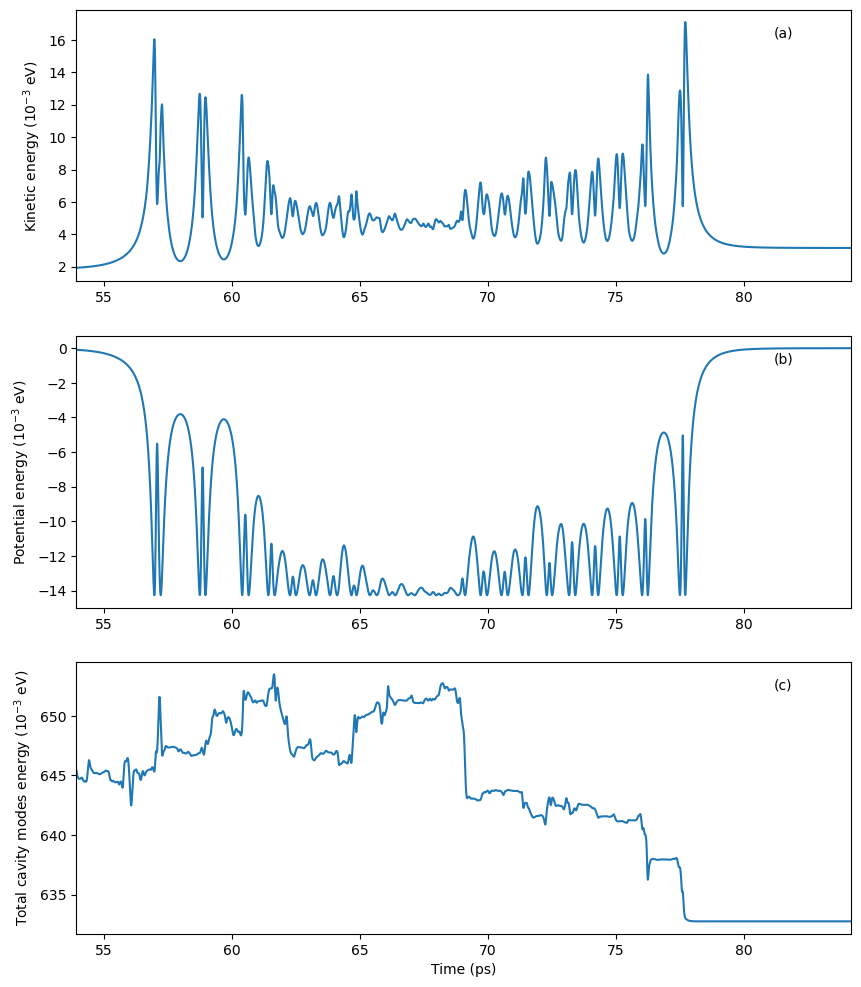

In [40]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
wn_list = red.convert_wavenumber(field.k_val)

In [ ]:
fig,ax = plt.subplots(3,figsize = (8,12))

hem = np.array(field.history['energy'])

t0 = 190; tf = 205
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[0].plot(x, y)
ax[0].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 250; tf = 275
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[1].plot(x,y)
ax[1].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 230; tf = 240
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[2].plot(x,y)
ax[2].vlines(22.766, min(y), max(y), linestyle = 'dotted')


In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = i , N_pairs = N_pairs, save_path = 'figure2/longest_anime')

In [ ]:
def calculate_impact_param(atoms):
    #first N_pairs atoms are Ar, last arre Xe
    N_pairs = int(len(atoms.r) / 2)

    d_ar_xe0 = - np.array(atoms.trajectory['r'][0][:N_pairs])
    d_ar_xe0 += np.array(atoms.trajectory['r'][0][N_pairs:])
    d_abs = np.sqrt(np.einsum("ni,ni->n", d_ar_xe0, d_ar_xe0))

    v_ar0 = np.array(atoms.trajectory['r_dot'][0][:N_pairs])
    v_ar0_abs = np.sqrt(np.einsum("ni,ni->n", v_ar0, v_ar0))

    dot = np.einsum("ni,ni->n", d_ar_xe0, v_ar0)
    angle = np.arccos(dot / (d_abs * v_ar0_abs))

    h = np.sin(angle) * d_abs

    return h

def calculate_def_angle(atoms):
    def angle(v1,v2):
        dot = np.einsum("ni,ni->n", v1,v2)
        v1_norm = np.sqrt(np.einsum("ni,ni->n",v1,v1))
        v2_norm = np.sqrt(np.einsum("ni,ni->n",v2,v2))
        angle = np.arccos(dot / (v1_norm * v2_norm))
        return angle * 360 / (2 * np.pi)
        
    N_pairs = int(len(atoms.r) / 2)

    v_ar_i = np.array(atoms.trajectory['r_dot'][0][:N_pairs])
    v_ar_f = np.array(atoms.trajectory['r_dot'][-1][:N_pairs])

    v_xe_i = np.array(atoms.trajectory['r_dot'][0][N_pairs:])
    v_xe_f = np.array(atoms.trajectory['r_dot'][-1][N_pairs:])

    return angle(v_ar_i,v_ar_f), angle(v_xe_i,v_xe_f)

fig,ax = plt.subplots(2,2)

all_defa_ar = []
all_defa_xe = []

for i, rd in freefield_result_dict.items():
    atoms = rd['atoms']

    ar_defangle, xe_defangle = calculate_def_angle(atoms) 

    all_defa_ar += list(ar_defangle)
    all_defa_xe += list(xe_defangle)

ax[0,0].hist(all_defa_ar, bins = np.arange(0, 180, 1) )
ax[0,1].hist(all_defa_xe, bins = np.arange(0, 180, 1) )

all_defa_ar = []
all_defa_xe = []

for i, rd in cavityfield_result_dict.items():
    atoms = rd['atoms']

    ar_defangle, xe_defangle = calculate_def_angle(atoms) 

    all_defa_ar += list(ar_defangle)
    all_defa_xe += list(xe_defangle)

ax[1,0].hist(all_defa_ar, bins = np.arange(0, 180, 1) )
ax[1,1].hist(all_defa_xe, bins = np.arange(0, 180, 1) )

In [ ]:
red.convert_wavenumber(field.k_val)

In [ ]:
for i, (temp, result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):

    if i == 0: continue
    result_dict = categorizing_result(result_path)

    for j in result_dict.keys():
        atoms = result_dict[j]['atoms']
        field = result_dict[j]['field']
    
        k = np.array(atoms.observable['kinetic'])
        v = np.array(atoms.observable['potential'])
        
        hrad = np.sum(field.history['energy'], axis = 1)
        t = field.history['t']
        
        total = k + v + hrad
        print(red.convert_energy(
            (total[0] - total[-1]) / (512*3 + 300 * 2),
            'ev'
        ))

In [ ]:
red.convert_energy(1 / (512 * 3 + 300) , 'ev')